# Flight Analysis

Update the flight report for a given flight/test campaign here: [Flight Reports](https://docs.google.com/document/d/1VsCrQUb__Pi3hgEoIxLOPsOpnpXVnwqD2DVSPG8jg84/edit#)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flight_plot_utils import load_csv, plot_angle, plot_rate

In [3]:
%matplotlib notebook

# Data Processing

In [55]:
# Load flight logs
flight_df = load_csv("flight_145")
flight_df.head(n=1500)

,t,is_crashed,roll,pitch,yaw,p,q,r,throttle,p_cmd,...,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,7074,0,2.125,-2.0625,-0.125,0.18,-0.24,-0.296875,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,7086,0,0.000,0.0000,-0.125,-8.68,8.42,0.103906,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
2,7096,0,0.000,0.0000,-0.125,0.06,-0.06,0.123945,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
3,7106,0,0.000,0.0000,-0.125,0.00,-0.06,0.362447,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
4,7116,0,0.000,0.0000,-0.125,0.06,-0.12,0.255622,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,24057,0,0.000,0.0625,-0.125,0.00,0.06,-0.068601,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
1496,24066,0,0.000,0.0625,-0.125,0.00,0.00,-0.122180,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
1497,24077,0,0.000,0.0625,-0.125,0.06,0.06,-0.124859,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
1498,24086,0,0.000,0.0625,-0.125,0.00,-0.18,-0.006243,0.007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819


In [56]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int32)
t_np = t_np / 1000

# Crashed flag
crash_df = flight_df[['is_crashed']]
crash_np = crash_df.to_numpy()

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

# Roll / Pitch / Yaw Commands - DF -> Numpy
rpy_cmd_df = flight_df[['roll_cmd', 'pitch_cmd', 'yaw_cmd']]
rpy_cmd_np = rpy_cmd_df.to_numpy()

# Roll / Pitch / Yaw Rates - DF -> Numpy
pqr_df = flight_df[['p', 'q', 'r']]
pqr_np = pqr_df.to_numpy()

# PID Outputs - DF -> Numpy
pid_df = flight_df[['roll_pid_out', 'pitch_pid_out', 'yaw_pid_out', 'p_cmd', 'q_cmd', 'r_cmd']]
pid_np = pid_df.to_numpy()

# Motor % - DF -> Numpy
power_df = flight_df[['motor_fl', 'motor_bl', 'motor_fr', 'motor_br']]
power_np = power_df.to_numpy()

# Throttle - DF -> Numpy
throttle_df = flight_df['throttle']
throttle_np = throttle_df.to_numpy()

In [57]:
# Trim off the pre-flight data where throttle wasn't up.
init_idx = flight_df.index[flight_df['throttle'] >= 0.0].to_list()[0]

# Plotting indices
idx_start = init_idx
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]

In [58]:
""" 
Data clipping
"""

is_crash = crash_np[idx_start:idx_end]
throttle = throttle_np[idx_start:idx_end]

roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

roll_cmd = rpy_cmd_np[idx_start:idx_end, 0]
pitch_cmd = rpy_cmd_np[idx_start:idx_end, 1]
yaw_cmd = rpy_cmd_np[idx_start:idx_end, 2]

p = pqr_np[idx_start:idx_end, 0]
q = pqr_np[idx_start:idx_end, 1]
r = pqr_np[idx_start:idx_end, 2]

p_pid = pid_np[idx_start:idx_end, 0]
q_pid = pid_np[idx_start:idx_end, 1]
r_pid = pid_np[idx_start:idx_end, 2]
roll_pid = pid_np[idx_start:idx_end, 3]
pitch_pid = pid_np[idx_start:idx_end, 4]
yaw_pid = pid_np[idx_start:idx_end, 5]

# Note: p,q,r cmds are the outer loop PID outputs.
p_cmd = roll_pid
q_cmd = pitch_pid
r_cmd = yaw_pid

# Crash Detection

<IPython.core.display.Javascript object>


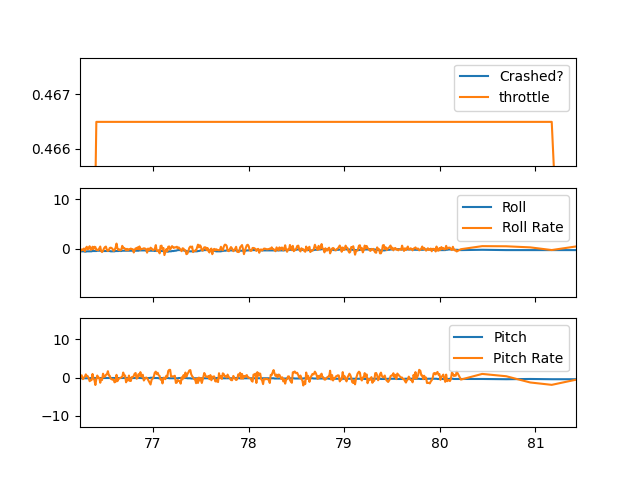

In [59]:
f, axs = plt.subplots(3, sharex=True)

axs[0].plot(t_clip, is_crash, label="Crashed?")
axs[0].plot(t_clip, throttle, label="throttle")
# axs[0].set_ylabel("Crash Status")
axs[0].legend()

axs[1].plot(t_clip, roll, label="Roll")
axs[1].plot(t_clip, p, label="Roll Rate")
axs[1].legend()

axs[2].plot(t_clip, pitch, label="Pitch")
axs[2].plot(t_clip, q, label="Pitch Rate")
axs[2].legend()

plt.show()

# Roll Control

## Inner Loop

<IPython.core.display.Javascript object>


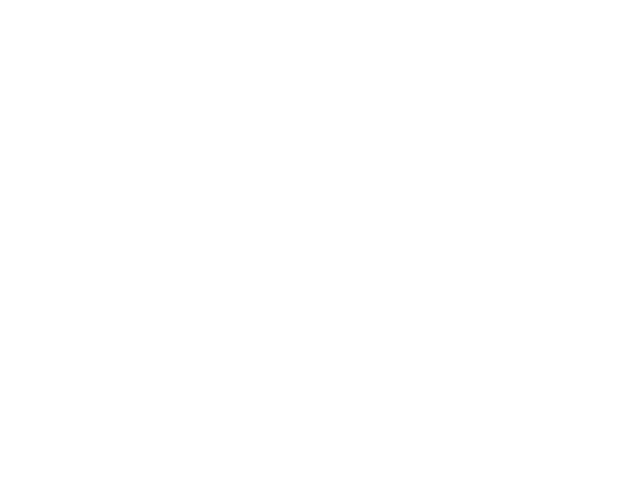

In [54]:
p_pid_gains = [-0.001, -0.000001, -0.001 / 40]
plot_rate(t_clip, p_cmd, p, np.gradient(p, t_clip), p_pid, "p", p_pid_gains)

## Outer Loop

<IPython.core.display.Javascript object>


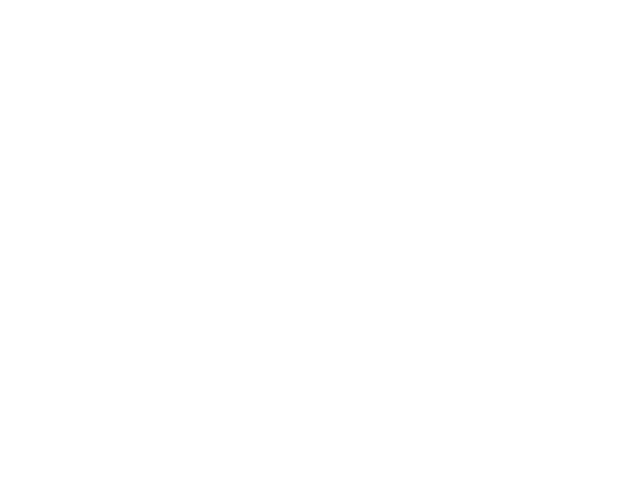

In [43]:
plot_angle(t_clip, roll_cmd, roll, p, np.degrees(roll_pid), label="roll")

# Pitch Control

## Inner Loop

<IPython.core.display.Javascript object>


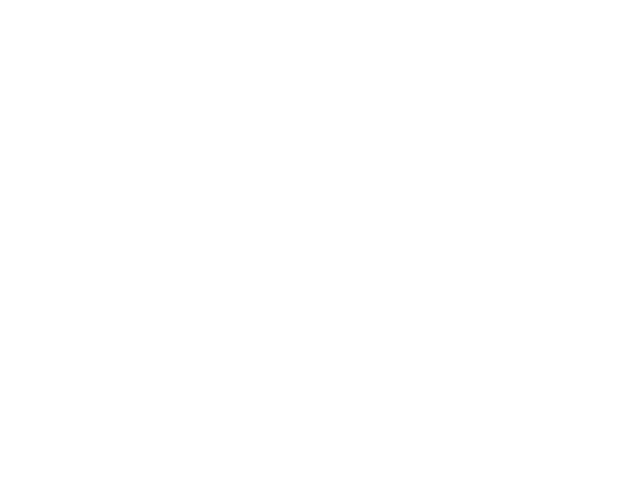

In [44]:
plot_rate(t_clip, q_cmd, q, np.gradient(q, t_clip), q_pid, "q")

## Outer Loop

<IPython.core.display.Javascript object>


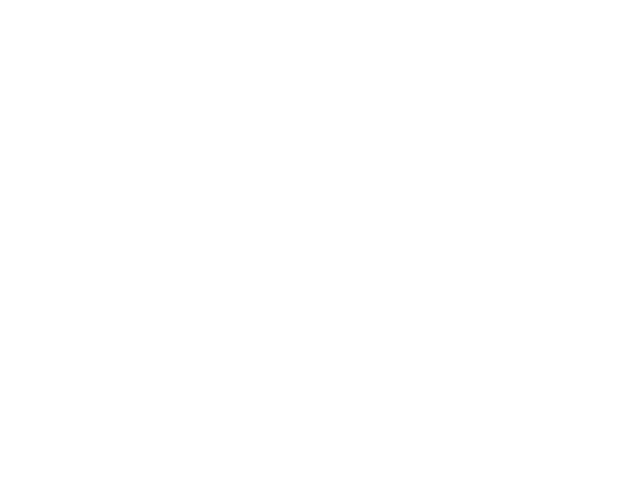

In [45]:
plot_angle(t_clip, pitch_cmd, pitch, q, np.degrees(pitch_pid), label="pitch")

# Yaw Control

## Inner Loop

<IPython.core.display.Javascript object>


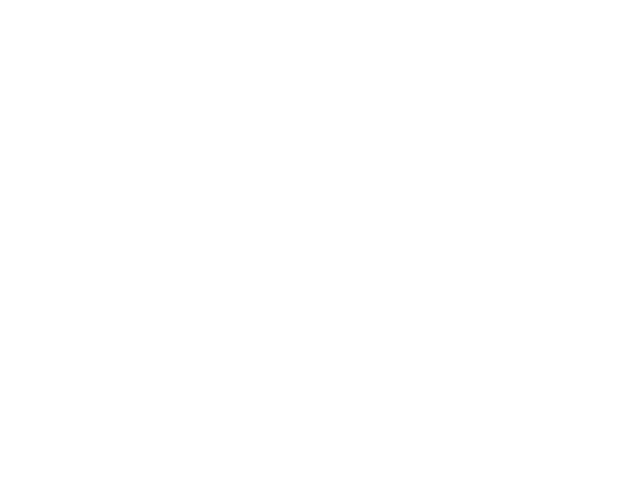

In [46]:
plot_rate(t_clip, r_cmd, r, np.gradient(r, t_clip), r_pid, "r")

## Outer Loop

<IPython.core.display.Javascript object>


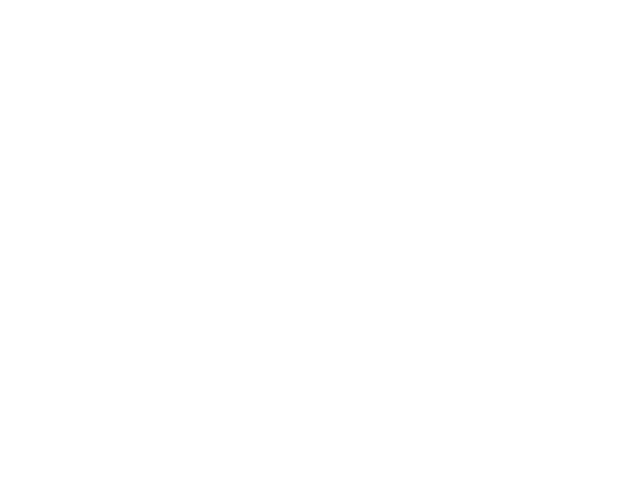

In [47]:
plot_angle(t_clip, yaw_cmd, yaw, r, yaw_pid, label="yaw")

# Motor Allocation

In [48]:
MAX_PWM = 2**14 - 1

def motor_pwm_to_pct(pwm, min_pwm_duty=0.051*MAX_PWM, max_pwm_duty=0.1*MAX_PWM):
    # Get PWM range in microseconds
    duty_range = max_pwm_duty - min_pwm_duty
    
    # Get the pwm distance from the lower limit
    pwm_offset = pwm - min_pwm_duty
    
    # Find the power
    power = pwm_offset / duty_range
    
    return power

<IPython.core.display.Javascript object>


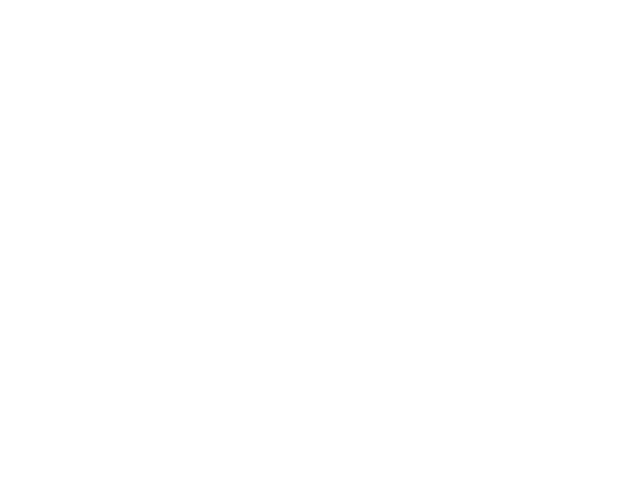

In [49]:
throttle_pct = throttle #* 0 + 0.5
front_left_out  = throttle_pct - p_pid + q_pid + r_pid
back_left_out   = throttle_pct - p_pid - q_pid - r_pid
front_right_out = throttle_pct + p_pid + q_pid - r_pid
back_right_out  = throttle_pct + p_pid - q_pid + r_pid

# Get actual motor powers
fl_power = power_np[idx_start:idx_end, 0]
bl_power = power_np[idx_start:idx_end, 1]
fr_power = power_np[idx_start:idx_end, 2]
br_power = power_np[idx_start:idx_end, 3]

# Plotting expected motor thrust allocation
f, axs = plt.subplots(4, sharex=True)

axs[0].plot(t_clip, front_left_out, label='calculated')
axs[0].plot(t_clip, fl_power, label='actual')
axs[0].set_ylabel("FL (%)")
axs[0].legend()

axs[1].plot(t_clip, back_left_out, label='calculated')
axs[1].plot(t_clip, bl_power, label='actual')
axs[1].set_ylabel("BL (%)")
axs[1].legend()

axs[2].plot(t_clip, front_right_out, label='calculated')
axs[2].plot(t_clip, fr_power, label='actual')
axs[2].set_ylabel("FR (%)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()

axs[3].plot(t_clip, back_right_out, label='calculated')
axs[3].plot(t_clip, br_power, label='actual')
axs[3].set_ylabel("BR (%)")
axs[3].set_xlabel("Time (s)")
axs[3].legend()

f.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


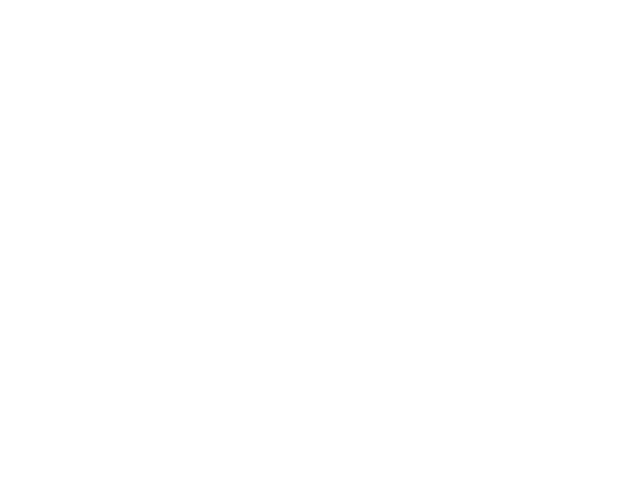

In [50]:
# Left - Right
front_delta = fl_power - fr_power
back_delta  = bl_power - br_power

# Plotting expected motor thrust allocation
f, axs = plt.subplots(2, sharex=True)

axs[0].plot(t_clip, front_delta)
axs[0].set_ylabel("Front (%)")

axs[1].plot(t_clip, back_delta)
axs[1].set_ylabel("Back (%)")

f.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


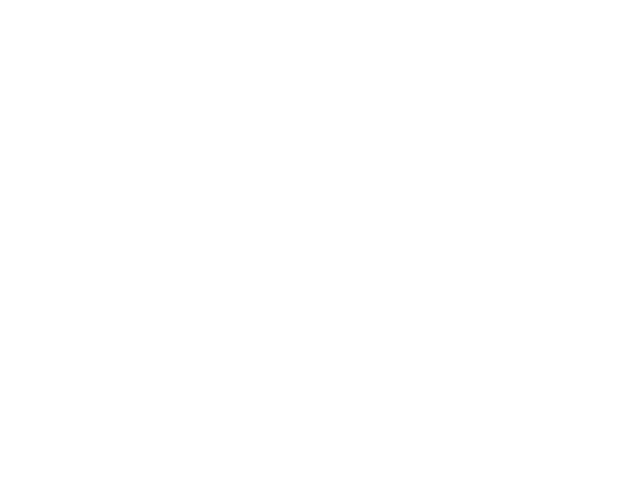

In [51]:
# Motor Vectors
front_power = (fl_power + fr_power) / 2.0
left_power = (fl_power + bl_power) / 2.0
back_power = (bl_power + br_power) / 2.0
right_power = (fr_power + br_power) / 2.0

# Effective controls
motor_roll = right_power - left_power
motor_pitch = front_power - back_power
motor_yaw = (fl_power + br_power) - (fr_power + bl_power)

fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(t_clip, motor_roll, label='motor')
axs[0].plot(t_clip, p_pid, label='cmd')
axs[0].set_ylabel("Roll Actuator")
axs[0].legend()
axs[0].grid()

axs[1].plot(t_clip, motor_pitch, label='motor')
axs[1].plot(t_clip, q_pid, label='cmd')
axs[1].set_ylabel("Pitch Actuator")
axs[1].legend()
axs[1].grid()

axs[2].plot(t_clip, motor_yaw, label='motor')
axs[2].plot(t_clip, r_pid, label='cmd')
axs[2].set_ylabel("Yaw Actuator")
axs[2].legend()
axs[2].grid()

fig.tight_layout()
plt.show()